# Shuttlt bus data analysis

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math

### functions

In [3]:
#坐标系转平面坐标
def mct2x(lat):
    x = lat/ 20037508.3427892 * 180 
    #y = lon/ 20037508.3427892 * 180 
    #y = 180 / math.pi * (2 * math.atan(math.exp(y * math.pi / 180)) - math.pi / 2) 
    return x
def mct2y(lon):
    result = []
    for i in lon:
        y = i/ 20037508.3427892 * 180 
        y = 180 / math.pi * (2 * math.atan(math.exp(y * math.pi / 180)) - math.pi / 2) 
        result.append(y)
    return result

# record should order by longitude first
def core_field_extra(stops,records):
   
    df =pd.DataFrame(columns = ['segment','distance(meter)','frequency','span'])
    segment = ''
    distance = 0
    frequency = 0
    span = 0
    
    bus_tracker = 0
    last_raw = records.iloc[[0]]
    for raw in records.itertuples():
        if(bus_tracker < len(stops)):
            flag = raw.latitude < stops.iloc[[bus_tracker]].latitude
            if(flag.any()):
                    continue
            elif(bus_tracker+1 < len(stops)):
                if((raw.latitude >= stops.iloc[[bus_tracker]].latitude).any() & (raw.latitude <= stops.iloc[[bus_tracker+1]].latitude).any()):
                    frequency = frequency + 1
                    segment = stops.iloc[bus_tracker,10] + '-' + stops.iloc[bus_tracker+1,10]
                    distance = distance + calculate_distance(last_raw.latitude,last_raw.longitude,
                                                             raw.latitude,raw.longitude)
#                     span = span + raw.updated - last_raw.updated
                    last_raw = raw
#                     print(raw)
#                     continue
        
                else:
                   df = df.append({'segment':segment,'distance(meter)':distance,'frequency':frequency,'span':span},ignore_index=True)
                   segment = ''
                   distance = 0
                   frequency = 0
                   span = 0 
#                    print("*************************** change ***********************")
                   bus_tracker= bus_tracker + 1 
#             else:
#                 print("*************************** change2 ***********************")
#                 bus_tracker = bus_tracker + 1
    return df
        
def calculate_distance(lat1,lng1,lat2,lng2):
    radlat1= math.radians(lat1)  
    radlat2=math.radians(lat2)  
    a=radlat1-radlat2  
    b=math.radians(lng1)-math.radians(lng2)  
    s=2*math.asin(math.sqrt(math.pow(math.sin(a/2),2)+math.cos(radlat1)*math.cos(radlat2)*math.pow(math.sin(b/2),2)))  
    earth_radius = 6371.393  
    s=s*earth_radius  
    if(s<0):
        return -s*1000
    else:
        return s*1000
 

### load file

In [4]:
#get the stop segment
csv_stop = pd.read_csv("./../data/iot.stops.csv",sep = '\t',header = 0)
csv_route = pd.read_csv("./../data/iot.routes.csv",sep = '\t',header = 0)

#for calculate the distances between 2 stops 
csv_record = pd.read_csv("./../data/iot.locations.csv",sep = '\t',header = 0)

## 1. data display

In [5]:
# link route and stop info together
csv_route_num1 = csv_route[(csv_route.routeNumber ==1) & (csv_route.isGo2Work == True) ]
csv_route_num1 = csv_route_num1.sort_values(["seqNumber"],ascending = True)
csv_route_num1 = csv_route_num1.iloc[:,1:7]

route_stops = csv_route_num1.merge(csv_stop,left_on='stopId',right_on = '_id')

In [6]:
route_stops.head(10)

,busId,isGo2Work,plannedArrivalTime,routeNumber,seqNumber,stopId,_id,isGoToWork,latitude,longitude,stopName,updated
0,5ae8393c3023169da447c2ae,True,7:23,1,1,5ae83320748fb2a67c5f6e54,5ae83320748fb2a67c5f6e54,True,22.249541,113.520559,明珠中,2018-05-01T09:28:00.844Z
1,5ae8393c3023169da447c2ae,True,7:26,1,2,5ae8334c748fb2a67c5f6e55,5ae8334c748fb2a67c5f6e55,True,22.256653,113.519771,翠微,2018-05-01T09:28:44.366Z
2,5ae8393c3023169da447c2ae,True,7:34,1,3,5ae8336c748fb2a67c5f6e56,5ae8336c748fb2a67c5f6e56,True,22.267762,113.536134,仁恒星园,2018-05-01T09:29:16.147Z
3,5ae8393c3023169da447c2ae,True,7:37,1,4,5ae834df567e17937cf407e1,5ae834df567e17937cf407e1,True,22.268722,113.542062,香洲区府,2018-05-01T09:35:27.388Z
4,5ae8393c3023169da447c2ae,True,7:38,1,5,5ae83521567e17937cf407e2,5ae83521567e17937cf407e2,True,22.269261,113.545517,南村,2018-05-01T09:36:33.812Z
5,5ae8393c3023169da447c2ae,True,7:40,1,6,5ae8353d567e17937cf407e3,5ae8353d567e17937cf407e3,True,22.276603,113.557696,兴业中,2018-05-01T09:37:01.373Z
6,5ae8393c3023169da447c2ae,True,8:30,1,7,5af85642ac5680781c7bb90c,5af85642ac5680781c7bb90c,True,22.372631,113.575924,南方软件园,2018-05-13T15:14:10.382Z


In [7]:
#filter 2018-5-18 
csv_record_bus1 = csv_record[(csv_record['bus']== 1.0)
                              & (csv_record['device']== 'stm32')
                              & (pd.to_datetime(csv_record['updated'],utc = True) > pd.to_datetime('2018/05/29 23:00',utc = True))
                              & (pd.to_datetime(csv_record['updated'],utc = True) < pd.to_datetime('2018/05/30 00:40',utc = True))] # filter all bus1 data

In [8]:
csv_record_bus1 = csv_record_bus1.sort_values(by = 'updated',ascending = True)
bus1_copy = csv_record_bus1.copy()
location = bus1_copy.iloc[:,3:5]

location.head()

,latitude,longitude
3134,22.249014,113.520707
3135,22.249225,113.520638
3136,22.249286,113.520600
3137,22.249292,113.520736
3138,22.249290,113.520820


In [9]:
#location.rename(columns={'longitude':'longtitude'}, inplace = True)

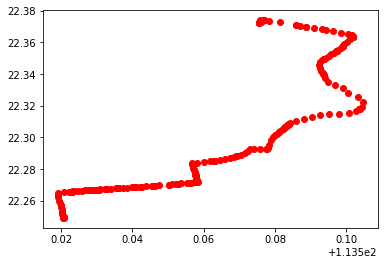

In [10]:
plt.plot(location['longitude'],location['latitude'],'ro')

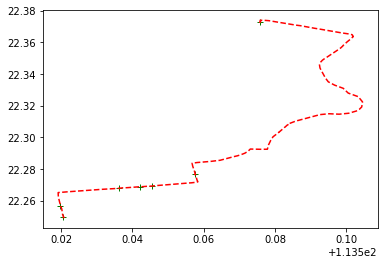

In [11]:
plt.plot(route_stops.longitude,route_stops.latitude, "g+",location['longitude'],location['latitude'],'r--')

## 2.data extra

In [12]:
x = core_field_extra(route_stops,location)
x

,segment,distance(meter),frequency,span
0,明珠中-翠微,842.417694,9,0
1,翠微-仁恒星园,2765.725818,45,0
2,仁恒星园-香洲区府,664.013761,13,0
3,香洲区府-南村,313.341765,2,0
4,南村-兴业中,1929.270900,45,0
5,兴业中-南方软件园,15786.833396,119,0
